In [1]:
import requests
import json
# import prettytable
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline

####State and Area Employment, Hours and Earnings (SM) 

http://download.bls.gov/pub/time.series/sm/

from sm.txt, find series id for hourly earnings in private sector in california


In [2]:
# data_type_code
lookup_dataType = pd.read_csv("data/smdata_type.txt", delimiter="\t", index_col=False)
earnings = lookup_dataType[lookup_dataType.data_type_text.str.contains("Hourly Earnings of All Employees")].data_type_code
hours = lookup_dataType[lookup_dataType.data_type_text.str.contains("Weekly Hours of All Employees")].data_type_code

# area_code
lookup_areaCode = pd.read_csv("data/smarea.txt", delimiter="\t", index_col=False)
area = lookup_areaCode[lookup_areaCode.area_name.str.contains("San Francisco")].area_code

# industry_code, don't need for SF because industry is Total Private
# lookup_industry = pd.read_csv("smindustry.txt", delimiter="\t", index_col=False)

In [3]:
#find series to post requests
series = pd.read_csv("data/smseries.txt", delim_whitespace=True)
series_earnings = series[series.data_type_code.isin(earnings.values) & \
                         (series.industry_code == 5000000) & (series.state_code == 6)].series_id.values
# sf : series.area_code.isin(area.values) & \
series_hours = series[series.data_type_code.isin(hours.values) & \
                       (series.industry_code == 5000000) & (series.state_code == 6)].series_id.values

In [4]:
api_key = 'a4c5b701a8604c5a98f3e4a92a83c4f6'
def get_data(seriesid_array):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(seriesid_array), 'registrationKey': api_key,
                      "startyear": "2000", "endyear": "2015"})
    #multiple series id use post
    p = requests.post('http://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text) 
    df = pd.DataFrame(columns=["series id","year","period","value","footnotes"])
    i = 0
    for s in json_data['Results']['series']:
        seriesId = s['seriesID']
        for item in s['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
           #'if 'M01' <= period <= 'M12':'
                df.loc[i] = (seriesId,year,period,value,footnotes[0:-1])
                i+=1
    return df
#     output = open(seriesId + '.txt','w')
#     output.write (x.get_string())
#     output.close()
df_earn = get_data(series_earnings)
df_hour = get_data(series_hours)

In [5]:
def add_area(df):
    lookup = series.join(lookup_areaCode.set_index('area_code'), on = 'area_code')
    df1 = df.join(lookup.set_index('series_id')['area_name'], on = 'series id')
    df1.value = df1.value.astype(float)
    df1.year = df1.year.astype(int)
    return df1
df_earn1 = add_area(df_earn)
df_hour1 = add_area(df_hour)
earn_hour = df_earn1.join(df_hour1.set_index(['area_name', 'year', 'period'])['value'], 
                          on=['area_name', 'year', 'period'], rsuffix='h')
#convert period and year to time series
y, m = list(earn_hour.year.values.astype(str)), [str(int(i[1:])) for i in earn_hour.period.values]
earn_hour['timeperiod'] = [pd.Period(yr+ "-" + mo) for (yr, mo) in zip(y, m)]
#save as csv so will not need to pull data from api everytime
earn_hour.to_csv("data/ca_earnings.csv") 

#### Find trends between years
From 2007 to 2015, the average hourly earnings of all employees in major metropolitan divisions has an increasing trend. Only in 2012 does the value decrease a little when compared to 2011 (economy dipped a little in 2012). 
Assuming the population in all cities is the same, the average hourly earnings of all employees in California also has an increasing trend. 

In [6]:
met = earn_hour[earn_hour.area_name.str.contains("Metropolitan Division")]
cities = earn_hour[~earn_hour.area_name.str.contains("Metropolitan Division")]
avg_yr_area = met.groupby(['year', 'area_name']).value.mean().unstack()
#df1.groupby(['year', 'area_name']).value.mean().unstack()
avg_yr_month = cities.groupby(['year', 'period']).value.mean().unstack()
# avg_yr_month.sub(avg_yr_month.loc[2007]) # avg_yr_month.diff()
pd.concat((avg_yr_month.mean(1), avg_yr_area), axis = 1) #simple cities average, metropolitan division average)

,0,"Anaheim-Santa Ana-Irvine, CA Metropolitan Division","Los Angeles-Long Beach-Glendale, CA Metropolitan Division","Oakland-Hayward-Berkeley, CA Metropolitan Division","San Francisco-Redwood City-South San Francisco, CA Metropolitan Division","San Rafael, CA Metropolitan Division"
year,,,,,,
2007,21.932685,27.288333,22.553333,27.649167,32.436667,NaN
2008,22.550586,26.546667,22.445833,28.585000,34.500833,NaN
2009,22.989074,26.506667,23.518333,29.365833,33.955833,NaN
2010,23.187500,26.646667,24.642500,29.636667,34.044167,NaN
2011,23.333241,26.707500,24.798333,29.982500,35.601667,32.552500
2012,23.547068,26.565000,24.723333,29.261667,33.955833,31.924167
2013,23.738704,27.405833,25.271667,29.346667,34.647500,31.635000
2014,24.033272,28.165833,26.014167,30.065833,35.742500,30.140000
2015,24.483951,28.568333,26.431667,30.820000,38.298333,30.326667


#### Histogram of earnings by year for cities (use subplots)

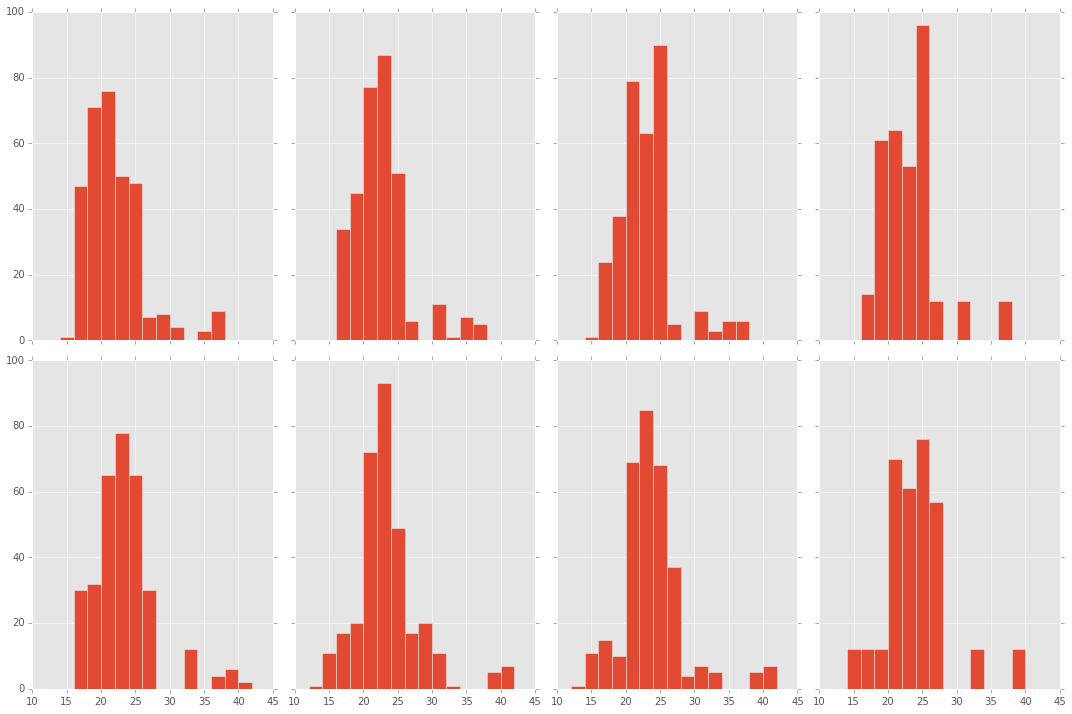

In [7]:
# plot histogram for each year for all cities (exclude metropolitan division to avoid double counting)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
b = np.arange(10, 45, 2)
ax1 = plt.subplot(241)
for i in range(1,9): #plot 2007 to 2014 (2015 is current year so not all data is available)
    ax2 = plt.subplot(int('24'+str(i)), sharex=ax1, sharey=ax1) #use same x and y axis for easy comparison
    plt.hist(cities[cities.year == 2006+i]['value'].values, bins=b)
    if i <5:
        plt.setp(ax2.get_xticklabels(), visible=False)
    if (i not in [1, 5]):
        plt.setp(ax2.get_yticklabels(), visible=False)
    
plt.tight_layout()

#### Compare earnings and weekly hours by metropolitan division
earnings and hours have very low correlation values

In [8]:
df_earn_hour = pd.pivot_table(earn_hour, index='area_name', columns='timeperiod', values=['value', 'valueh']).stack(1)
earn_hour.corr()

,year,value,valueh
year,1.000000,0.160148,0.023846
value,0.160148,1.000000,0.244009
valueh,0.023846,0.244009,1.000000


####Create scatterplot to show lack of correlation between earnings and hours for all cities

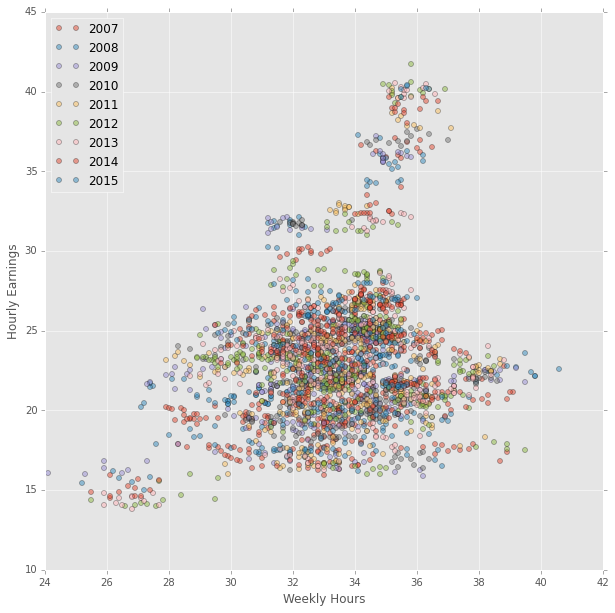

In [9]:
#color each scatter by year
g_cities = cities.groupby('year')

# Plot
fig, ax = plt.subplots(figsize=(10,10))
for name, group in g_cities:
    ax.plot(group['valueh'], group['value'], marker='o', linestyle='', ms=5, label=name, alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel('Weekly Hours')
ax.set_ylabel('Hourly Earnings')

plt.show()

####Time series plots by major metropolitan areas. 
1 for earnings and 1 for hours

In [10]:
met_earn = pd.pivot_table(met, values = 'value', index='timeperiod', columns='area_name')
met_hour = pd.pivot_table(met, values = 'valueh', index='timeperiod', columns='area_name')
met_earn.index = met_earn.index.to_datetime()
met_hour.index = met_earn.index.to_datetime()

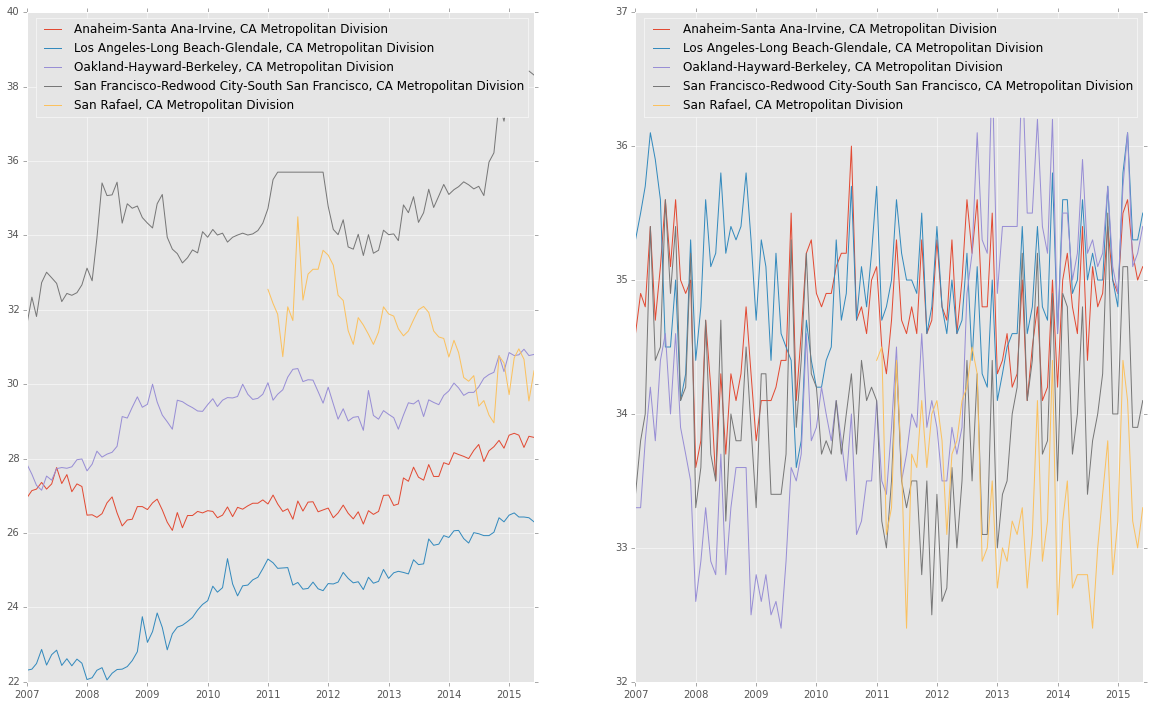

In [11]:
fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))

plt.subplot(121)
for col in met_earn.columns:
    plt.plot(met_earn.index, met_earn[col], label= col)
plt.legend()

plt.subplot(122)
for col in met_hour.columns:
    plt.plot(met_hour.index, met_hour[col], label=col)
plt.legend()


####Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

It seems that for all metropolitan divisions besides San Rafael have increasing earnings trend over time.  It does not seem like there is a correlation between weekly hours and earnings. 
I would like to test if the average hourly earnings between San Rafael and Oakland are the same because 2011 earnings for San Rafael is greater than Oakland but 2015 earnings for San Rafael is less than Oakland.

####By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete? 

I want to look at the average hourly earnings in California using data from the Bureau of Labor Statistics.  Because different areas have different cost of living, earnings in metropolitan areas are different. 

The histogram shows the increasing trend in earnings over the years assuming that all metropolitan areas are equal in size and weight.  

The scatterplot shows a lack of correlation between average weekly hours and average hourly earnings. 

The time series plot shows an increasing trend in earnings with time (except for San Rafael). The time series plot also shows the difference between average hourly earnings of metropolitan areas in California.  

Additionally population in cities will help calculate average hourly earnings in California. So without population information, I'd like to see how cities in metropolitan areas affect the trend; this may show how the cities are weighted by metropolitan area (ie: San Francisco has a larger population than Redwood City so the average earnings should be weighted more heavily than Redwood City when computing the average earnings for the San Francisco metropolitan area).